### 1. Подключение необходимых библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})

In [2]:
"""Функция посчета метрик"""
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### 2. Загрузка данных

#### 2.1 Пути к директориям и файлам

In [3]:
TRAIN_DATASET_PATH = 'E:/GB учеба/VSuprygin_predictions/Dataset/train.csv'
TEST_DATASET_PATH = 'E:/GB учеба/VSuprygin_predictions/Dataset/test.csv'

#### 2.2 Описание датасета

- **Id** - идентификационный номер квартиры
- **DistrictId** - идентификационный номер района
- **Rooms** - количество комнат
- **Square** - площадь
- **LifeSquare** - жилая площадь
- **KitchenSquare** - площадь кухни
- **Floor** - этаж
- **HouseFloor** - количество этажей в доме
- **HouseYear** - год постройки дома
- **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
- **Social_1, Social_2, Social_3** - социальные показатели местности
- **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
- **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
- **Price** - цена квартиры

#### 2.3 Набор данных для обучения - TRAIN

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


#### 2.4 Тестовый набор данных - TEST

In [5]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [6]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [7]:
train_df.shape[1] - 1 == test_df.shape[1] # в тестовом наборе нет столбца с ценой

True

#### 2.5 Приведение типов данных

In [8]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [9]:
# идентификаторы не несут смысловой нагшрузки для обучения, исключим их из параметров, присвоив им строковый тип
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### 3. EDA

#### 3.1 Целевая переменная

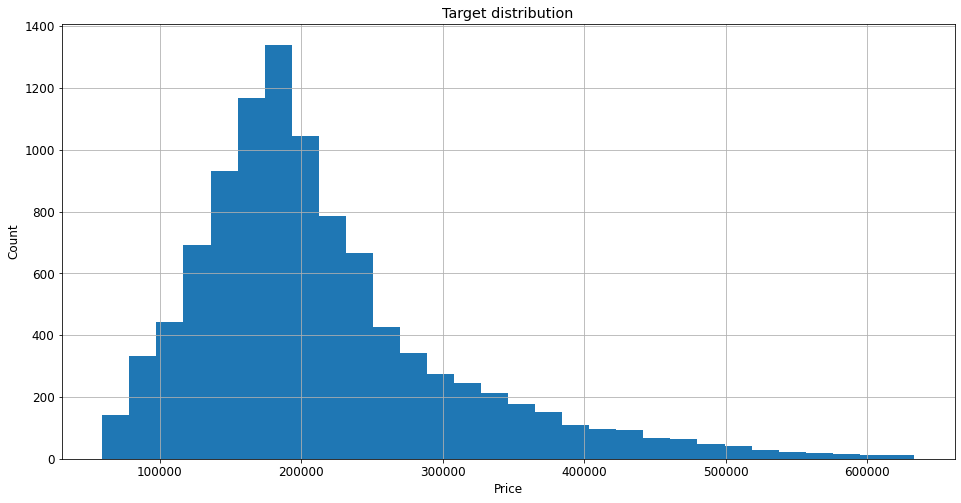

In [10]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Классическое логнормальное распределение без явных выбросов

#### 3.2 Количественные признаки

In [11]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### 3.3 Номинативные признаки

In [12]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [13]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [14]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [15]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [16]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

#### 3.4 Обработка выбросов

Проверка данных: общая площадь должна быть не меньше жилой площади плюс площадь кухни квартиры/дома.

In [17]:
true_square = train_df.query('LifeSquare + KitchenSquare > Square')
true_square

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
33,847,74,2.0,73.314975,74.131261,1.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863
34,7757,27,2.0,58.783661,55.441256,11.0,13,12.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,138396.984612
42,8576,4,2.0,53.179791,50.643797,5.0,5,12.0,1976,0.042032,B,B,37,6856,84,1940.0,2,5,B,308108.233873
48,12307,60,1.0,40.064914,38.733288,8.0,13,14.0,1974,0.007659,B,B,35,7077,56,2301.0,3,19,B,160810.546681
64,3992,1,3.0,87.200625,87.730225,0.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.365669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.385617
9979,2201,6,1.0,40.043234,41.984322,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.083598
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.192698


Достаточно много квартир с жилой площадью плюс кухня, которые больше общей площади. 

Варианты обработки данных:

1. Ничего не делать, оставить как есть.
2. Удалить такие данные из рассмотрения.
3. Исправить общую площадь: берем равной сумме жилой площади и кухни.
4. Исправить жилую площадь: берем равной разности общей площади и кухни.

#### Rooms

In [18]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Создаем новый столбец 'Rooms_outlier', в котором 1 означает наличие выброса, 0 - его отсутствие. Это показатель, можно ли доверять данным по числу комнат в этой строке.

In [19]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [20]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1  # если нет комнат, то ставим минимум одну комнату
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median() # очень много комнат - ставим медианное значение

In [21]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### KitchenSquare

In [22]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [23]:
# Проверим есть ли явная зависимость между жилой площадью и площадью кухни.
kithchen_S_vs_life_S = train_df[['KitchenSquare', 'LifeSquare']]

In [24]:
kithchen_S_vs_life_S = kithchen_S_vs_life_S.dropna()
kithchen_S_vs_life_S_111 = kithchen_S_vs_life_S.query('(KitchenSquare >= 3) & (KitchenSquare <= 13)')
kithchen_S_vs_life_S_111 = kithchen_S_vs_life_S_111.query('(LifeSquare >= 10) & (LifeSquare <= 150)')
kithchen_S_vs_life_S_111

,KitchenSquare,LifeSquare
1,8.0,23.169223
2,10.0,47.671972
4,9.0,38.562517
5,6.0,47.103833
6,9.0,21.772930
...,...,...
9995,6.0,33.272626
9996,9.0,37.038420
9997,5.0,16.555363
9998,5.0,22.326870


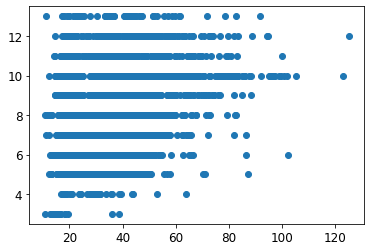

In [25]:
plt.scatter(kithchen_S_vs_life_S_111['LifeSquare'], kithchen_S_vs_life_S_111['KitchenSquare'])
plt.show()

Зависимости площади кухни от жилой площади на вычищенных данных найти не удалось.

In [26]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [27]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [28]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

#### HouseFloor, Floor

In [29]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [30]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

Этажность квартиры за пределами этажности дома:

In [31]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [32]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [33]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

# есть риск, что медианное значение окажется "неподходящим" - меньше этажа квартиры, далее это исправляется.

In [34]:
# Определяем индексы таких квартир/домов

floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [35]:
# Квартирам с наденными индексами присваиваем рандомно этаж с 1 по максимально возможный в здании.

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [36]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

#### HouseYear

In [37]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [38]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

#### 3.5 Обработка пропусков

In [39]:
# Считаем пропуски

train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

#### LifeSquare

In [40]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

#### Healthcare_1

In [41]:
# В признаке Healthcare_1 отсутствует cлишком много данных, удаляем его полностью.

train_df.drop('Healthcare_1', axis=1, inplace=True)

#### 3.6 Задаем класс по обработке данных

In [42]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        #X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        #Square
        
        # X.loc[X['KitchenSquare'] + X['LifeSquare'] > X['Square'], 'Square'] = X['KitchenSquare'] + X['LifeSquare']
        #X.loc[X['KitchenSquare'] + X['LifeSquare'] > X['Square'], 'LifeSquare'] = X['Square'] - X['KitchenSquare']
        #X=X.query('LifeSquare + KitchenSquare <= Square')
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

#### 3.7 Построение новых признаков

#### Dummies

In [43]:
# Заменяем строковые значения признаков на численные, чтобы их можно было использовать в обучении модели 

binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

#### DistrictSize, DistrictLarge

Номер района, в котором находится дом, мало о чем говорит, поэтому создаем признак, показывающий число квартир в этом районе.

In [44]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


Присоединяем district_size к train_df по полю DistrictId, получая новый признак DistrictSize в train_df.

In [45]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,3097,0,0,0,1,305018.871089,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1,0,1,177734.553407,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,3,1,1,282078.720850,0,0,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,264,0,0,1,1,168106.007630,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,0,6,1,343995.102962,0,0,0,89


Делаем выборку "больших" районов (квартир больше 100)

In [46]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

Вводим новый признак - DistrictLarge (более 100 квартир)

In [47]:
train_df['DistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

#### MedPriceByDistrict

MedPriceByDistrict - признак, cгруппированный по количеству комнат.

In [48]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [49]:
med_price_by_district.shape

(667, 3)

Присоединяем med_price_by_district к train_df по набору полей "DistrictId", "Rooms", получая новый признак MedPriceByDistrict в train_df.

In [50]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,DistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.871089,0,0,1,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.553407,0,0,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.720850,0,0,0,652,1,244005.272380
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,1,1,168106.007630,0,0,1,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0,0,89,0,201584.441255


#### MedPriceByDistrict_Square

Сделаем еще один признак по типу MedPriceByDistrict, только не с количеством комнат, а с общей площадью и добавим столбец с целочисленным значением общей площади.

In [51]:
train_df['Square_int'] = train_df['Square'].round().astype(int)
med_price_by_district_square = train_df.groupby(['DistrictId', 'Square_int'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict_Square'})

med_price_by_district_square.head()

,DistrictId,Square_int,MedPriceByDistrict_Square
0,0,17,88871.750230
1,0,20,102395.788856
2,0,31,158495.653884
3,0,32,125579.315184
4,0,33,152561.109032


In [52]:
med_price_by_district_square.shape

(4290, 3)

Присоединяем med_price_by_district_square к train_df по набору полей "DistrictId", "Square_int", получая новый признак MedPriceByDistrict_Square в train_df.

In [53]:
train_df = train_df.merge(med_price_by_district_square, on=['DistrictId', 'Square_int'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,DistrictLarge,MedPriceByDistrict,Square_int,MedPriceByDistrict_Square
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,1,305018.871089,0,0,1,851,1,213530.788443,115,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,177734.553407,0,0,0,78,0,146032.829834,40,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,282078.720850,0,0,0,652,1,244005.272380,78,218115.439256
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,1,168106.007630,0,0,1,652,1,146735.671740,40,143709.172001
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,343995.102962,0,0,0,89,0,201584.441255,64,343995.102962


#### MedPriceByFloorYear

Вводим новые признаки - floor_cat (категория этажа) и year_cat (категория года постройки), сведя все алгоритмы в виде процедур/функций.

In [54]:
# функция floor_to_cat выдает категорию для floor_cat в виде натурального числа 

def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X

# функция floor_to_cat_pandas выдает категорию для floor_cat в виде номера интервала или -1 (значения нет ни в одном интервале)

def floor_to_cat_pandas(X):
    bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

# функция year_to_cat выдает категорию для year_cat в виде натурального числа 

def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X

# функция year_to_cat_pandas выдает категорию для year_cat в виде номера интервала или -1 (значения нет ни в одном интервале)

def year_to_cat_pandas(X):
    bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [55]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,DistrictLarge,MedPriceByDistrict,Square_int,MedPriceByDistrict_Square,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,1,851,1,213530.788443,115,305018.871089,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,78,0,146032.829834,40,177734.553407,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,652,1,244005.272380,78,218115.439256,4,1
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,0,1,652,1,146735.671740,40,143709.172001,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,89,0,201584.441255,64,343995.102962,3,5


In [56]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,343812.494282
1,1,2,343290.170195
2,1,3,429090.881284
3,1,4,274992.472366
4,2,1,467230.539057


In [57]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,LifeSquare_nan,DistrictSize,DistrictLarge,MedPriceByDistrict,Square_int,MedPriceByDistrict_Square,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,1,851,1,213530.788443,115,305018.871089,6,2,163047.087076
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,78,0,146032.829834,40,177734.553407,3,3,191807.787174
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,652,1,244005.272380,78,218115.439256,4,1,204940.082609
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,1,652,1,146735.671740,40,143709.172001,3,4,183494.399043
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,89,0,201584.441255,64,343995.102962,3,5,171739.199220


#### 3.8 Задаем класс по созданию новых признаков

In [58]:
class FeatureGenetator():
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_district_square = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms, Square
        X['Square_int'] = X['Square'].round().astype(int)
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
#           self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'mean'})\
#                                            .rename(columns={'Price':'MedPriceByDistrict'})           
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
#            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].mean()

            self.med_price_by_district_square = df.groupby(['DistrictId', 'Square_int'], as_index=False)\
                               .agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict_Square'})
            self.med_price_by_district_square_median = self.med_price_by_district_square['MedPriceByDistrict_Square'].median()

        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
    
    def transform(self, X):
        
        X['Square_int'] = X['Square'].round().astype(int)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['DistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_district_square is not None:
            X = X.merge(self.med_price_by_district_square, on=['DistrictId', 'Square_int'], how='left')
            X['MedPriceByDistrict_Square'].fillna(self.med_price_by_district_square_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

#### 3.9 Отбор признаков

In [59]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'DistrictLarge',
 'MedPriceByDistrict',
 'Square_int',
 'MedPriceByDistrict_Square',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [60]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

feature_names_1 = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                'new_district', 'DistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

new_feature_names_1 = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                'new_district', 'DistrictLarge',  'MedPriceByDistrict', 'MedPriceByDistrict_Square', 'MedPriceByFloorYear']

new_feature_names_2 = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize', 
                       'DistrictLarge',  'MedPriceByDistrict', 'MedPriceByDistrict_Square', 'MedPriceByFloorYear']

new_feature_names_3 = ['MedPriceByDistrict_Square']

new_feature_names_4 = ['HouseFloor_outlier', 'LifeSquare_nan', 'DistrictSize', 
                       'DistrictLarge', 'MedPriceByFloorYear']

target_name = 'Price'

### 4. Разбиение на train и test

In [61]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [63]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [64]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan
9239,11585,23,1.0,43.380798,37.380798,3.0,18,25.0,1977,0.075779,...,6,1437,3,0,2,B,0,0,0,1
6930,2917,30,3.0,83.596365,77.596365,3.0,3,16.0,1977,0.000078,...,22,6398,141,3,23,B,0,0,0,1
8136,9635,47,2.0,53.610583,31.289235,8.0,4,12.0,1979,0.298205,...,16,4048,3,1,3,B,0,1,0,0
3424,8748,3,2.0,51.877576,30.075022,6.0,3,9.0,1974,0.265089,...,37,5288,0,3,2,B,0,0,0,0
6518,5704,62,1.0,53.810968,47.810968,3.0,4,13.0,1977,0.072158,...,2,629,1,0,0,A,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,10466,84,3.0,76.698682,55.477526,8.0,3,5.0,1960,0.006076,...,30,5285,0,6,6,B,0,1,0,0
48,12307,60,1.0,40.064914,38.733288,8.0,13,14.0,1974,0.007659,...,35,7077,56,3,19,B,0,0,0,0
8964,47,2,2.0,45.053898,47.329346,5.0,2,5.0,1967,0.000000,...,33,7425,1,2,5,B,0,0,0,0
5944,161,71,1.0,40.337987,24.811220,8.0,5,12.0,1984,0.407276,...,9,1768,0,0,0,A,0,0,0,0


In [65]:
X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 31), (3300, 31), (5000, 31))

In [66]:
X_train = X_train[feature_names_1 + new_feature_names_4]
X_valid = X_valid[feature_names_1 + new_feature_names_4]
test_df = test_df[feature_names_1 + new_feature_names_4]

In [67]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 5. Построение модели

#### 5.1 Обучение

In [68]:
rfr_model = RandomForestRegressor(n_estimators=15, max_depth = 10, min_samples_leaf = 10, random_state=21, criterion='mse')
rfr_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=10, min_samples_leaf=10,
                      n_estimators=15, random_state=21)

#### 5.2 Оценка модели

Train R2:	0.789
Test R2:	0.727


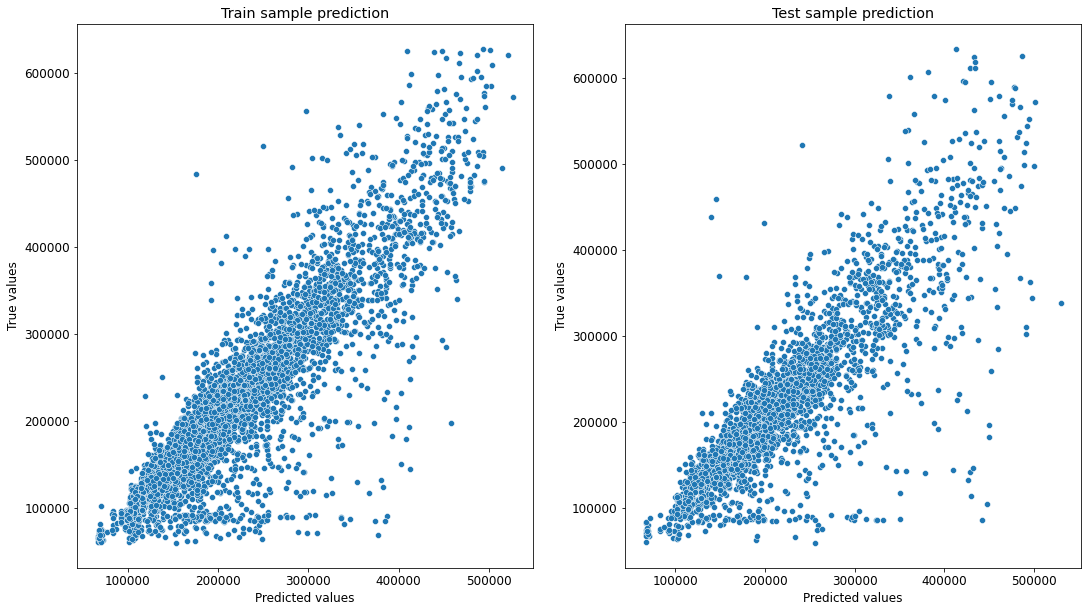

In [69]:
y_train_preds = rfr_model.predict(X_train)
y_test_preds = rfr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### 5.3 Кросс-валидация

In [70]:
cv_score = cross_val_score(rfr_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=4, shuffle=True, random_state=21))
cv_score

array([0.7044417 , 0.6909804 , 0.7047346 , 0.70794348])

In [71]:
cv_score.mean()

0.702025045894462

#### 5.4 Важность признаков

In [72]:
feature_importances = pd.DataFrame(zip(X_train.columns, rfr_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.484917
16,DistrictSize,0.261479
10,Social_3,0.059806
0,Rooms,0.032682
9,Social_2,0.029181
7,Ecology_1,0.027519
8,Social_1,0.020400
18,MedPriceByFloorYear,0.016581
2,LifeSquare,0.015766
12,Shops_1,0.010481


### 6. Прогнозирование на TEST

In [73]:
test_df.shape

(5000, 19)

In [74]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,HouseFloor_outlier,LifeSquare_nan,DistrictSize,DistrictLarge,MedPriceByFloorYear
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,24,4378,0,1,1,1,0,0,76.0,0,188697.720287
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,2,629,1,0,0,0,0,0,164.0,1,179595.252204
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,9,1892,0,0,1,1,0,1,580.0,1,173028.982008
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,2,475,0,0,0,1,0,0,372.0,1,181393.404528
4,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,35,7715,4,0,6,1,0,1,65.0,0,193098.662333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,1,5.0,1962,0.069660,31,6119,4,1,2,1,1,0,56.0,0,177947.620710
4996,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,15,2787,2,0,7,1,0,0,26.0,0,198122.688122
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,28,6533,1,2,5,1,0,0,54.0,0,181393.404528
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,33,7976,5,0,11,1,0,0,40.0,0,193098.662333


In [75]:
SAMPLE_SUBMISSION_PATH = 'E:/GB учеба/VSuprygin_predictions/Dataset/sample_submission.csv'

In [76]:
submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)
submission.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [77]:
predictions = rfr_model.predict(test_df)
predictions

array([168310.55301295, 128747.80765383, 147610.82980904, ...,
       148952.77360202, 192405.29476994, 232108.82608901])

In [78]:
submission['Price'] = predictions
submission.head()

,Id,Price
0,4567,168310.553013
1,5925,128747.807654
2,960,147610.829809
3,3848,131740.305358
4,746,230881.559282


In [79]:
submission.to_csv('VSuprygin_predictions', index=False)